## Objective 

#### sound dataset 
https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz

The following will demonstrate how to apply Deep Learning techniques to the classification of environmental sounds, specifically focusing on the identification of particular urban sounds.

In [1]:
import librosa 
import numpy as np
import pandas as pd
import joblib
import random
set_seed = random.seed(0)

In [2]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = mfccs.flatten()
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
    return mfccsscaled


In [3]:
data_path = "/content/drive/My Drive/Colab Notebooks/sound_data.pkl"
data = joblib.load(data_path)

In [4]:
cls_name = []
cls_id = []
feature = []
for id ,cls,fet in data :
  if len(fet)==6920:
    cls_id.append(id)
    cls_name.append(cls)
    feature.append(fet)



In [5]:
feature = np.asarray(feature).reshape((len(feature),40,173))
cls_id = np.asarray(cls_id)
cls_name = np.asarray(cls_name)
print (feature.shape)
print (len(cls_id))
print (len(cls_name))

(7327, 40, 173)
7327
7327


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
cls_df = pd.DataFrame({'id':cls_id,'label':cls_name},columns=['id','label'])

cls_df

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,label
0,2,children_playing
1,2,children_playing
2,2,children_playing
3,2,children_playing
4,2,children_playing
...,...,...
7322,1,car_horn
7323,1,car_horn
7324,1,car_horn
7325,1,car_horn


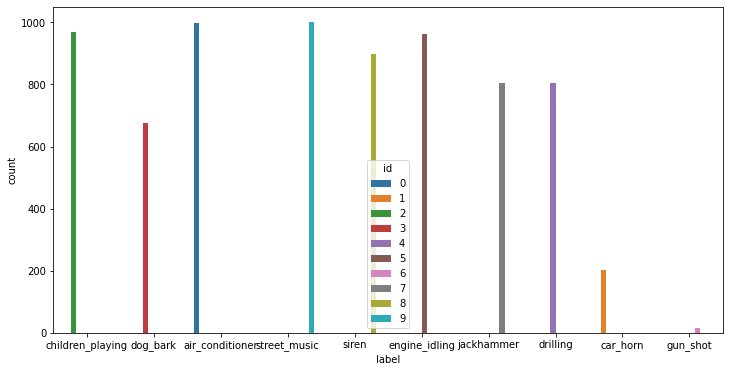

In [7]:
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(cls_df['label'],hue=cls_df['id'],ax=ax)

In [8]:
cls_dict = {}
cls_df = cls_df.set_index('id')
for cls in cls_df.label.unique():
  i = list((set(cls_df[cls_df['label']==cls].index.values)))[0]
  cls_dict[i]=cls

num_labels = len(cls_dict.keys())
print(cls_dict)
print(num_labels)

{2: 'children_playing', 3: 'dog_bark', 0: 'air_conditioner', 9: 'street_music', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling', 1: 'car_horn', 6: 'gun_shot'}
10


In [9]:
IMG_HEIGHT = 173
IMG_WIDTH = 40
CHANNEL = 1
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNEL)
print(IMG_SHAPE)

(40, 173, 1)


In [10]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
lb = LabelBinarizer()
print(cls_name)
labels_embedding = lb.fit_transform(cls_name) # one hot encoding
print(labels_embedding)

['children_playing' 'children_playing' 'children_playing' ... 'car_horn'
 'car_horn' 'car_horn']
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [11]:
x_train, x_test, y_train, y_test = train_test_split(feature, labels_embedding, test_size=0.2, random_state = set_seed )
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5861, 40, 173, 1)
(1466, 40, 173, 1)
(5861, 10)
(1466, 10)


In [12]:
INPUT_SHAPE = (x_train.shape[0],IMG_WIDTH, IMG_HEIGHT, CHANNEL)
print (INPUT_SHAPE)

(5861, 40, 173, 1)


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten ,BatchNormalization
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn import metrics 


Train a self designed Convolutional Neural Network

In [14]:
# Construct CNN model 

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(IMG_SHAPE), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu',kernel_regularizer=regularizers.l2()))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=2,activation='relu',kernel_regularizer=regularizers.l2()))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add (Conv2D(filters=128,kernel_size=2,activation='relu',kernel_regularizer=regularizers.l2()))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 86, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 42, 32)         1

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epochs,logs={}):
    if logs.get('accuracy')>0.99:
      print("Reached 90% accuracy cancelling training")
      self.model.stop_training=True
callbacks = myCallback()

In [17]:
EPOCHS = 100
INIT_LR = 1e-3
BATCH_SIZE = 256
steps_per_epoch=x_train.shape[0]//BATCH_SIZE
print (steps_per_epoch)
H = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    #steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
                    batch_size=BATCH_SIZE,
                    #callbacks=[callbacks],
                    validation_split=0.15)

22
Epoch 1/100
20/20 [==============================] - 1s 52ms/step - loss: 3.0917 - accuracy: 0.4238 - val_loss: 5.3222 - val_accuracy: 0.1727
Epoch 2/100
20/20 [==============================] - 1s 25ms/step - loss: 2.4541 - accuracy: 0.5975 - val_loss: 3.3454 - val_accuracy: 0.2489
Epoch 3/100
20/20 [==============================] - 0s 25ms/step - loss: 2.1004 - accuracy: 0.6515 - val_loss: 2.9623 - val_accuracy: 0.2330
Epoch 4/100
20/20 [==============================] - 0s 25ms/step - loss: 1.8065 - accuracy: 0.7049 - val_loss: 2.7732 - val_accuracy: 0.2057
Epoch 5/100
20/20 [==============================] - 0s 24ms/step - loss: 1.5727 - accuracy: 0.7398 - val_loss: 2.6306 - val_accuracy: 0.2136
Epoch 6/100
20/20 [==============================] - 1s 25ms/step - loss: 1.3977 - accuracy: 0.7627 - val_loss: 2.5431 - val_accuracy: 0.2886
Epoch 7/100
20/20 [==============================] - 0s 24ms/step - loss: 1.2592 - accuracy: 0.7814 - val_loss: 2.5066 - val_accuracy: 0.3182
Epo

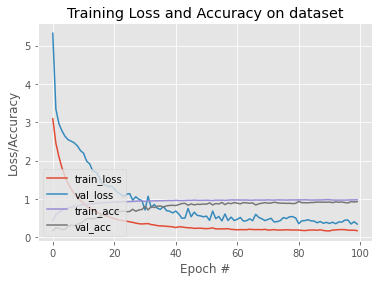

In [18]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [19]:
from sklearn.metrics import classification_report ,accuracy_score
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=BATCH_SIZE)
test_pred = np.argmax(predIdxs,axis=1)
y_pred_cls = [cls_dict[i] for i in test_pred]

ytest_cls = lb.inverse_transform(y_test)
accuracy_score(ytest_cls,y_pred_cls)

[INFO] evaluating network...


0.9085948158253752

In [20]:
#Download any dog bark sound  
! wget http://osabisi.sakura.ne.jp/m2/tm4/se/tm2_construction000.wav
mfcc_fet = extract_features('/content/tm2_construction000.wav')
mfcc_fet = np.asarray(mfcc_fet[:6920])
mfcc_fet=  mfcc_fet.reshape (1,IMG_WIDTH, IMG_HEIGHT,1)
mfcc_fet.shape

--2020-07-29 15:52:32--  http://osabisi.sakura.ne.jp/m2/tm4/se/tm2_construction000.wav
Resolving osabisi.sakura.ne.jp (osabisi.sakura.ne.jp)... 202.181.99.40
Connecting to osabisi.sakura.ne.jp (osabisi.sakura.ne.jp)|202.181.99.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1114156 (1.1M) [audio/x-wav]
Saving to: ‘tm2_construction000.wav’

tm2_construction000 100%[===================>]   1.06M  2.06MB/s    in 0.5s    

2020-07-29 15:52:33 (2.06 MB/s) - ‘tm2_construction000.wav’ saved [1114156/1114156]



(1, 40, 173, 1)

In [21]:
real_worldprediction = model.predict(mfcc_fet)
real_worldprediction = np.argmax(real_worldprediction)
cls_dict[real_worldprediction]

'street_music'

use Pretrained netowrk for this . 

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input ,Dense , GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50V2
resnet = ResNet50V2(weights='imagenet',include_top= 'False') 
for layers in resnet.layers[:100]:
  layers.trainable=True

input_tensor = Input(shape=(IMG_WIDTH, IMG_HEIGHT,1))
x = Conv2D(3,(3,3),padding='same',activation='relu')   # x has a dimension of (IMG_SIZE,IMG_SIZE,1)

# Trainable classification head
maxpool_layer = GlobalMaxPooling2D() # will be incompatible as it requires 3d input
prediction_layer = Dense(num_labels, activation='softmax')


102875136/102869336 [==============================] - 2s 0us/step


In [23]:
model = Sequential([
                    input_tensor,
                    x,
                    resnet,
                    #maxpool_layer,
                    prediction_layer])
# out = resnet


# model = Model(inputs=input_tensor,outputs=out)

In [24]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 40, 173, 3)        30        
_________________________________________________________________
resnet50v2 (Model)           (None, 1000)              25613800  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
Total params: 25,623,840
Trainable params: 25,578,400
Non-trainable params: 45,440
_________________________________________________________________


In [25]:
H = model.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=128,
              #steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
              validation_split=0.25
              )

Epoch 1/100
35/35 [==============================] - 7s 200ms/step - loss: 2.2609 - accuracy: 0.2853 - val_loss: 2.2708 - val_accuracy: 0.1473
Epoch 2/100
35/35 [==============================] - 5s 140ms/step - loss: 2.2224 - accuracy: 0.2953 - val_loss: 2.2674 - val_accuracy: 0.1091
Epoch 3/100
35/35 [==============================] - 5s 140ms/step - loss: 2.2052 - accuracy: 0.2348 - val_loss: 2.2509 - val_accuracy: 0.1501
Epoch 4/100
35/35 [==============================] - 5s 140ms/step - loss: 2.1700 - accuracy: 0.2623 - val_loss: 2.1983 - val_accuracy: 0.1623
Epoch 5/100
35/35 [==============================] - 5s 140ms/step - loss: 2.1367 - accuracy: 0.2787 - val_loss: 2.2514 - val_accuracy: 0.1385
Epoch 6/100
35/35 [==============================] - 5s 139ms/step - loss: 2.1083 - accuracy: 0.2610 - val_loss: 2.2276 - val_accuracy: 0.1426
Epoch 7/100
35/35 [==============================] - 5s 139ms/step - loss: 2.0696 - accuracy: 0.2699 - val_loss: 2.2404 - val_accuracy: 0.1364

In [26]:
mfcc_fet = extract_features('/content/labrador-barking-daniel_simon.wav')
mfcc_fet = np.asarray(mfcc_fet[:6920])
mfcc_fet=  mfcc_fet.reshape (1,IMG_WIDTH, IMG_HEIGHT,1)
print(mfcc_fet.shape)

real_worldprediction = model.predict(mfcc_fet)
real_worldprediction = np.argmax(real_worldprediction)
cls_dict[real_worldprediction]

NameError: ignored

In [ ]:
! wget http://osabisi.sakura.ne.jp/m2/tm4/se/tm2_construction000.wav
mfcc_fet = extract_features('/content/tm2_construction000.wav')
mfcc_fet = np.asarray(mfcc_fet[:6920])
mfcc_fet=  mfcc_fet.reshape (1,IMG_WIDTH, IMG_HEIGHT,1)
mfcc_fet.shape

In [ ]:
real_worldprediction = model.predict(mfcc_fet)
real_worldprediction = np.argmax(real_worldprediction)
cls_dict[real_worldprediction]